<a href="https://colab.research.google.com/github/kimle1128/FEWP/blob/main/PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DGS1MO.xlsx to DGS1MO.xlsx
Saving return.csv to return.csv
Saving esg.csv to esg.csv
Saving F-F_Research_Data_Factors.xlsx to F-F_Research_Data_Factors.xlsx
Saving gics_data.xlsx to gics_data.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

In [ ]:
sp_return = pd.read_csv('return.csv')
sp_esg = pd.read_csv('esg.csv')
gics = pd.read_excel('gics_data.xlsx')
ff_factors = pd.read_excel('F-F_Research_Data_Factors.xlsx')

### Data Preparation Functions

In [ ]:
def clean_esg(df):
    """
    Melts ESG data to long format and lags the year by 1
    (Signal Year T -> Portfolio Year T+1).
    """
    df = df.melt(id_vars=['Identifier', 'Company Name', 'TRBC Industry Name'],
                 var_name='Year_Signal', value_name='ESG_Score')
    df['Year_Signal'] = pd.to_numeric(df['Year_Signal'], errors='coerce')
    df['ESG_Score'] = pd.to_numeric(df['ESG_Score'], errors='coerce')
    df = df.dropna(subset=['Year_Signal', 'ESG_Score'])
    df['Year_Signal'] = df['Year_Signal'].astype(int)

    # Portfolio Year is the year AFTER the ESG score is released
    df['Year_Portfolio'] = df['Year_Signal'] + 1

    # Rank firms into Quintiles (1=Low, 5=High) within each year
    df['Quintile'] = df.groupby('Year_Signal')['ESG_Score'].transform(
        lambda x: pd.qcut(x, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    )
    return df

def clean_returns(df):
    """
    Melts return data, converts percentages to decimals, and parses dates.
    """
    # Identify date columns (assuming they contain '/')
    date_cols = [c for c in df.columns if '/' in c]
    df = df.melt(id_vars=['Identifier', 'Company Name', 'GICS Sector Name'],
                 value_vars=date_cols, var_name='Date_Str', value_name='Return')

    # Clean percentage strings (e.g., "5.2%") -> 0.052
    df['Return'] = df['Return'].astype(str).str.replace('%', '', regex=False)
    df['Return'] = pd.to_numeric(df['Return'], errors='coerce') / 100

    df['Date'] = pd.to_datetime(df['Date_Str'], format='%m/%d/%Y')
    df['Month_ID'] = df['Date'].dt.to_period('M')
    df['Year_Portfolio'] = df['Date'].dt.year

    return df.dropna(subset=['Return'])

def clean_gics(df):
    """
    Melts GICS weights data.
    """
    df = df.melt(id_vars='Time', var_name='GICS Sector Name', value_name='Weight')
    df['Date'] = pd.to_datetime(df['Time'])
    df['Month_ID'] = df['Date'].dt.to_period('M')
    df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce') / 100

    # Standardize Sector Names if necessary (e.g., 'Healthcare' -> 'Health Care')
    df['GICS Sector Name'] = df['GICS Sector Name'].replace({'Healthcare': 'Health Care'})
    return df

def clean_ff(df):
    """
    Cleans Fama-French 3-Factor data.
    """
    # Rename first column to Date if needed, or assume it is first
    df = df.rename(columns={df.columns[0]: 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
    df['Month_ID'] = df['Date'].dt.to_period('M')

    # Convert factors to decimals (e.g., 2.55 -> 0.0255)
    for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce') / 100

    return df

# Execute Cleaning
df_esg_clean = clean_esg(sp_esg)
df_returns_clean = clean_returns(sp_return)
df_gics_clean = clean_gics(gics)
df_ff_clean = clean_ff(ff_factors)

# Filter Returns for Analysis Period (2017-2024)
df_returns_clean = df_returns_clean[
    (df_returns_clean['Date'].dt.year >= 2017) &
    (df_returns_clean['Date'].dt.year <= 2024)
]

### Portfolio Construction (Sector-Neutral)

In [ ]:
# Merge Returns with ESG Quintiles
# This assigns an ESG Quintile to every stock for every month based on the previous year's score
df_merged = pd.merge(df_returns_clean,
                     df_esg_clean[['Identifier', 'Year_Portfolio', 'Quintile']],
                     on=['Identifier', 'Year_Portfolio'],
                     how='inner')

# Calculate "Bucket" Returns
# Average return of all stocks in a specific (Quintile, Sector) bucket
bucket_returns = df_merged.groupby(['Month_ID', 'Quintile', 'GICS Sector Name'])['Return'].mean().reset_index()

# Apply GICS Weights
# Merge bucket returns with the benchmark GICS weights for that month
portfolio_calc = pd.merge(bucket_returns,
                          df_gics_clean[['Month_ID', 'GICS Sector Name', 'Weight']],
                          on=['Month_ID', 'GICS Sector Name'],
                          how='inner')

# Calculate weighted contribution
portfolio_calc['Contribution'] = portfolio_calc['Return'] * portfolio_calc['Weight']

# Formula: Sum(Sector Return * Sector Weight) / Sum(Weights of sectors present in quintile)
# The denominator ensures we re-normalize if a quintile is missing a sector entirely.
quintile_returns = portfolio_calc.groupby(['Month_ID', 'Quintile']).apply(
    lambda x: x['Contribution'].sum() / x['Weight'].sum()
).reset_index(name='Portfolio_Return')

/tmp/ipython-input-1179788460.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_returns = df_merged.groupby(['Month_ID', 'Quintile', 'GICS Sector Name'])['Return'].mean().reset_index()
/tmp/ipython-input-1179788460.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_returns = portfolio_calc.groupby(['Month_ID', 'Quintile']).apply(
/tmp/ipython-input-1179788460.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=

In [ ]:
# Pivot to Wide Format
df_pivoted = quintile_returns.pivot(index='Month_ID', columns='Quintile', values='Portfolio_Return').reset_index()
df_pivoted['Date'] = df_pivoted['Month_ID'].dt.to_timestamp() + MonthEnd(0)

# Long Q1 (Low ESG) / Short Q5 (High ESG)
df_pivoted['Long_Short'] = df_pivoted['Q1'] - df_pivoted['Q5']
# General Portfolio (Average of all quintiles)
df_pivoted['General_Portfolio'] = df_pivoted[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].mean(axis=1)

### Run regression

In [ ]:
# Merge with Fama-French Factors
df_analysis = pd.merge(df_pivoted,
                       df_ff_clean[['Month_ID', 'Mkt-RF', 'SMB', 'HML', 'RF']],
                       on='Month_ID',
                       how='inner')

# Define Variables for Fama-French Regression
Y = df_analysis['Long_Short'] - df_analysis['RF'] # Dependent Variable (Strategy Excess Return)
X = df_analysis[['Mkt-RF', 'SMB', 'HML']] # Independent Variables (Factors)
X = sm.add_constant(X) # Adds Alpha

# Run OLS Regression
model = sm.OLS(Y, X).fit()

In [ ]:
print(df_analysis.head())

  Month_ID        Q1        Q2        Q3        Q4        Q5       Date  \
0  2017-01  0.024494  0.011383  0.006127  0.006164  0.005262 2017-01-31   
1  2017-02  0.043939  0.052504  0.044311  0.042851  0.041208 2017-02-28   
2  2017-03  0.008847  0.017771  0.012335  0.012828  0.012184 2017-03-31   
3  2017-04 -0.019828 -0.022812 -0.020173 -0.020145 -0.030016 2017-04-30   
4  2017-05  0.058135  0.047308  0.028948  0.051123  0.035679 2017-05-31   

   Long_Short  General_Portfolio  Mkt-RF     SMB     HML      RF  
0    0.019232           0.010686  0.0194 -0.0116 -0.0276  0.0004  
1    0.002731           0.044963  0.0355 -0.0215 -0.0150  0.0004  
2   -0.003337           0.012793  0.0017  0.0113 -0.0333  0.0003  
3    0.010188          -0.022595  0.0108  0.0066 -0.0205  0.0005  
4    0.022455           0.044239  0.0107 -0.0252 -0.0382  0.0006  


### Run CAPM regression (Long/Short vs Market Excess Return)

In [ ]:
# Define Variables for CAPM Regression
Y_capm = df_analysis['Long_Short'] - df_analysis['RF'] # Dependent Variable (Strategy Excess Return)
X_capm = df_analysis[['Mkt-RF']] # Independent Variable (Market Excess Return)
X_capm = sm.add_constant(X_capm) # Adds Alpha

# Run OLS Regression
model_capm = sm.OLS(Y_capm, X_capm).fit()

In [ ]:
print("\n" + "="*50)
print("CAPM REGRESSION RESULTS")
print("Strategy: Long Q1 (Low ESG) / Short Q5 (High ESG) vs. Market Excess Return")
print("="*50)
print(model_capm.summary())


CAPM REGRESSION RESULTS
Strategy: Long Q1 (Low ESG) / Short Q5 (High ESG) vs. Market Excess Return
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.072
Date:                Tue, 02 Dec 2025   Prob (F-statistic):             0.0266
Time:                        20:25:17   Log-Likelihood:                 227.78
No. Observations:                  96   AIC:                            -451.6
Df Residuals:                      94   BIC:                            -446.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
alpha_monthly_capm = model_capm.params['const']
alpha_annual_capm = (1 + alpha_monthly_capm)**12 - 1
t_stat_capm = model_capm.tvalues['const']
p_val_capm = model_capm.pvalues['const']

print(f"\nMonthly Alpha (CAPM): {alpha_monthly_capm:.4%}")
print(f"Annualized Alpha (CAPM): {alpha_annual_capm:.4%}")
print(f"Alpha t-stat (CAPM): {t_stat_capm:.4f} (Sig if > 1.96 or < -1.96)")


Monthly Alpha (CAPM): 0.5403%
Annualized Alpha (CAPM): 6.6793%
Alpha t-stat (CAPM): 2.2655 (Sig if > 1.96 or < -1.96)


In [ ]:
print("\n" + "="*50)
print("FAMA-FRENCH 3-FACTOR REGRESSION RESULTS")
print("Strategy: Long Q1 (Low ESG) / Short Q5 (High ESG)")
print("="*50)
print(model.summary())


FAMA-FRENCH 3-FACTOR REGRESSION RESULTS
Strategy: Long Q1 (Low ESG) / Short Q5 (High ESG)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     10.62
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           4.63e-06
Time:                        20:26:29   Log-Likelihood:                 239.53
No. Observations:                  96   AIC:                            -471.1
Df Residuals:                      92   BIC:                            -460.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [ ]:
alpha_monthly = model.params['const']
alpha_annual = (1 + alpha_monthly)**12 - 1
t_stat = model.tvalues['const']
p_val = model.pvalues['const']

print(f"\nMonthly Alpha: {alpha_monthly:.4%}")
print(f"Annualized Alpha: {alpha_annual:.4%}")
print(f"Alpha t-stat: {t_stat:.4f} (Sig if > 1.96 or < -1.96)")


Monthly Alpha: 0.5570%
Annualized Alpha: 6.8922%
Alpha t-stat: 2.5791 (Sig if > 1.96 or < -1.96)


### Descriptive statistics and plotting

In [ ]:
stats_cols = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Long_Short', 'General_Portfolio']
desc_stats = df_analysis[stats_cols].agg(['mean', 'std'])
desc_stats.loc['mean'] = desc_stats.loc['mean'] * 12 # Annualize Mean
desc_stats.loc['std'] = desc_stats.loc['std'] * np.sqrt(12) # Annualize Std
desc_stats.loc['Sharpe'] = (desc_stats.loc['mean'] - df_analysis['RF'].mean()*12) / desc_stats.loc['std']
desc_stats.loc['N_Observations'] = df_analysis[stats_cols].count().values # Add number of observations

# Round to 3 decimal places
desc_stats = desc_stats.round(3)

print("\n--- Annualized Descriptive Statistics ---")
print(desc_stats.T)


--- Annualized Descriptive Statistics ---
                    mean    std  Sharpe  N_Observations
Q1                 0.245  0.187   1.202            96.0
Q2                 0.193  0.171   1.005            96.0
Q3                 0.172  0.175   0.864            96.0
Q4                 0.186  0.167   0.989            96.0
Q5                 0.146  0.150   0.831            96.0
Long_Short         0.100  0.081   0.978            96.0
General_Portfolio  0.188  0.166   1.008            96.0


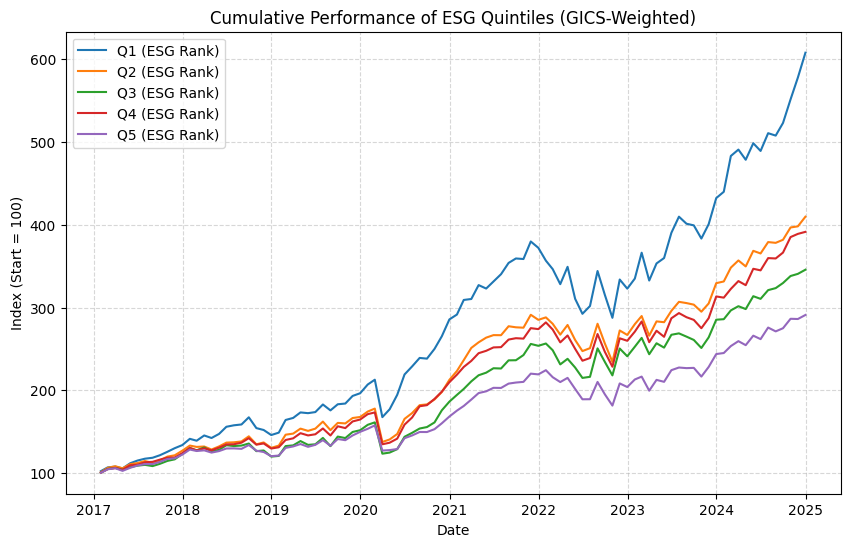

In [ ]:
# Plot 1: Cumulative Performance of Quintiles
plt.figure(figsize=(10, 6))
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    cum_ret = (1 + df_analysis[q]).cumprod() * 100
    plt.plot(df_analysis['Date'], cum_ret, label=f'{q} (ESG Rank)')

plt.title('Cumulative Performance of ESG Quintiles (GICS-Weighted)')
plt.ylabel('Index (Start = 100)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

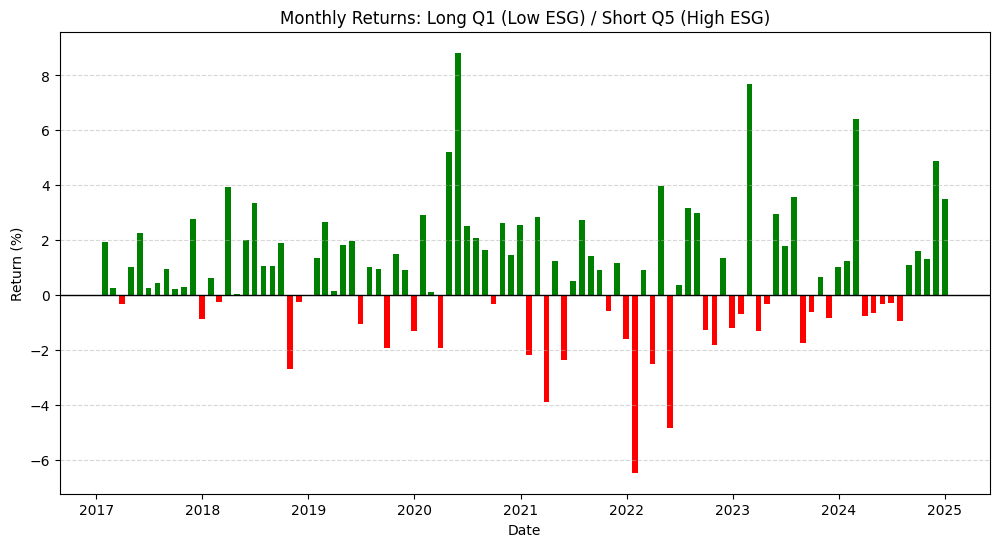

In [ ]:
# Plot 2: Strategy Monthly Returns
plt.figure(figsize=(12, 6))
colors = ['green' if x >= 0 else 'red' for x in df_analysis['Long_Short']]
plt.bar(df_analysis['Date'], df_analysis['Long_Short'] * 100, color=colors, width=20)
plt.axhline(0, color='black', linewidth=1)
plt.title('Monthly Returns: Long Q1 (Low ESG) / Short Q5 (High ESG)')
plt.ylabel('Return (%)')
plt.xlabel('Date')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

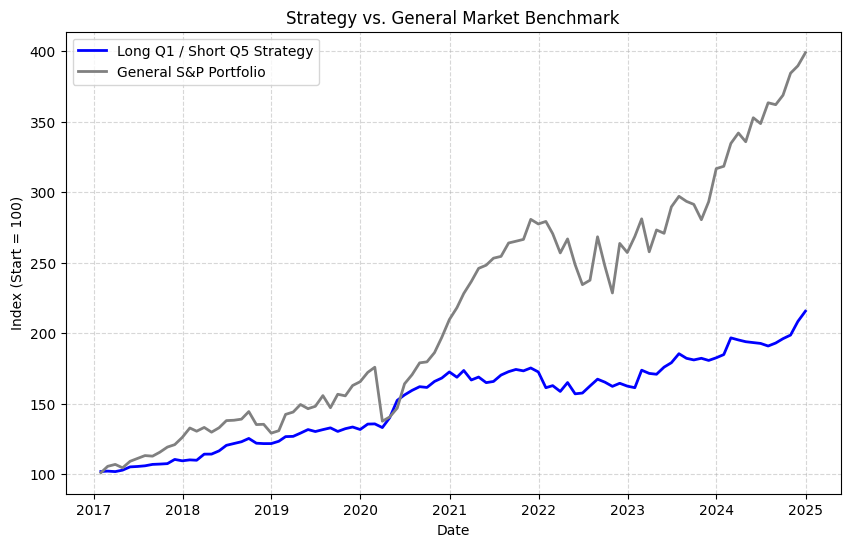

In [ ]:
# Plot 3: Strategy vs Benchmark
plt.figure(figsize=(10, 6))
cum_ls = (1 + df_analysis['Long_Short']).cumprod() * 100
cum_gen = (1 + df_analysis['General_Portfolio']).cumprod() * 100

plt.plot(df_analysis['Date'], cum_ls, label='Long Q1 / Short Q5 Strategy', color='blue', linewidth=2)
plt.plot(df_analysis['Date'], cum_gen, label='General S&P Portfolio', color='grey', linewidth=2)

plt.title('Strategy vs. General Market Benchmark')
plt.ylabel('Index (Start = 100)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
df_pivoted.to_excel('df_pivoted.xlsx', index=False)

In [ ]:
# Calculate cumulative returns for all quintiles and the Long_Short strategy
cumulative_df = pd.DataFrame({'Date': df_analysis['Date']})
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Long_Short']:
    cumulative_df[f'Cum_{q}'] = (1 + df_analysis[q]).cumprod()
    # Rebase to 100
    cumulative_df[f'Cum_{q}'] = cumulative_df[f'Cum_{q}'] / cumulative_df[f'Cum_{q}'].iloc[0] * 100

cumulative_df.to_excel('cumulative_returns_all_quintiles.xlsx', index=False)
print("Cumulative returns for all quintiles and Long/Short strategy exported to 'cumulative_returns_all_quintiles.xlsx'")

Cumulative returns for all quintiles and Long/Short strategy exported to 'cumulative_returns_all_quintiles.xlsx'


In [ ]:
df_analysis.to_excel('df_analysis.xlsx', index = False)

In [ ]:
alpha_annual = alpha_monthly * 12
residual_std_monthly = model.resid.std()
residual_std_annual = residual_std_monthly * np.sqrt(12)
information_ratio = alpha_annual / residual_std_annual
print("\n--- Information Ratio (Appraisal Ratio) Analysis ---")
print(f"Annualized Alpha: {alpha_annual:.2%}")
print(f"Annualized Residual Volatility: {residual_std_annual:.2%}")
print(f"Information Ratio: {information_ratio:.4f}")


--- Information Ratio (Appraisal Ratio) Analysis ---
Annualized Alpha: 6.68%
Annualized Residual Volatility: 6.95%
Information Ratio: 0.9616


In [ ]:
def calculate_drawdown(series):
    # Compounding cumulative return
    cum_ret = (1 + series).cumprod()
    # Running maximum
    running_max = cum_ret.cummax()
    # Drawdown
    drawdown = (cum_ret - running_max) / running_max
    return drawdown


In [ ]:
df_analysis['DD_Q1'] = calculate_drawdown(df_analysis['Q1'])
df_analysis['DD_Q5'] = calculate_drawdown(df_analysis['Q5'])
df_analysis['DD_LS'] = calculate_drawdown(df_analysis['Long_Short'])
df_analysis['DD_G'] = calculate_drawdown(df_analysis['General_Portfolio'])

mdd_q1 = df_analysis['DD_Q1'].min()
mdd_q5 = df_analysis['DD_Q5'].min()
mdd_ls = df_analysis['DD_LS'].min()
mdd_g = df_analysis['DD_G'].min()

print(f"Max Drawdown Q1: {mdd_q1:.2%}")
print(f"Max Drawdown Q5: {mdd_q5:.2%}")
print(f"Max Drawdown Long/Short: {mdd_ls:.2%}")
print(f"Max Drawdown General Portfolio: {mdd_g:.2%}")

Max Drawdown Q1: -24.27%
Max Drawdown Q5: -19.30%
Max Drawdown Long/Short: -10.45%
Max Drawdown General Portfolio: -21.76%


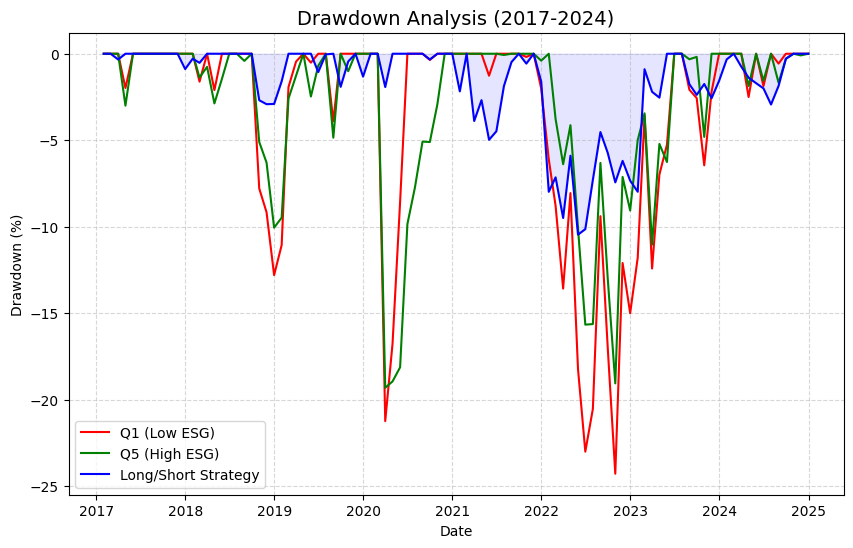

In [ ]:
# --- Plotting Drawdowns ---
plt.figure(figsize=(10, 6))
plt.plot(df_analysis['Date'], df_analysis['DD_Q1'] * 100, label='Q1 (Low ESG)', color='red', linewidth=1.5)
plt.plot(df_analysis['Date'], df_analysis['DD_Q5'] * 100, label='Q5 (High ESG)', color='green', linewidth=1.5)
plt.plot(df_analysis['Date'], df_analysis['DD_LS'] * 100, label='Long/Short Strategy', color='blue', linewidth=1.5)
plt.fill_between(df_analysis['Date'], df_analysis['DD_LS'] * 100, 0, color='blue', alpha=0.1)

plt.title('Drawdown Analysis (2017-2024)', fontsize=14)
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)